In [10]:
import scipy
import pickle
import numpy as np
from tqdm import tqdm_notebook as tqdm
from scipy.linalg import norm
from sklearn.datasets import load_svmlight_file
import matplotlib.pyplot as plt

In [13]:
W, y = load_svmlight_file('./data/cod-rna')

In [14]:
# параметры алгоритма
n = W.shape[0]
p = W.shape[1]
R = 1
x = np.zeros(p)
lam  = np.max(np.sqrt(np.sum(W.power(2), axis=1)))**2 / (4 * n)
bias = 0
terminate_tol = 1e-8
sub_tol = 0.25 * terminate_tol
steps_tol = 0.25
n_steps = 500
alpha = 2 # alpha = 3
Lest = 1
s_deactive = 0
printst = 10

In [15]:
def fn_logis_Val(y, W, bias, x, lam, topv=None):
    
    if topv is None:
        topv = np.exp(-y * (W * x + bias))
    Valv = np.log(1 + topv)
    Val1 = np.sum(Valv) / n
    Val2 = 0.5 * lam * (np.dot(x, x))
    Val = Val1 + Val2
    return Val

In [16]:
def fn_logis_Grad(y, W, bias, x, lam):
    Top = np.exp(-y * ( W * x  + bias)) # why minus?
    Rat = Top / (1 + Top)
    LM = -Rat * y
    ResM = scipy.sparse.diags(LM) * W
    Grad = ResM.sum(axis=0).A1 + lam * n * x
    return Grad, Top

In [17]:
def projection_simplex_sort(v, z=1):
    n_features = v.shape[0]
    u = np.sort(v)[::-1]
    cssv = np.cumsum(u) - z
    ind = np.arange(n_features) + 1
    cond = u - cssv / ind > 0
    rho = ind[cond][-1]
    theta = cssv[cond][-1] / float(rho)
    w = np.maximum(v - theta, 0)
    return w

def l1_ball_projection(y, z=R):
    if norm(y, 1) <= R:
        return y
    pos_proj = projection_simplex_sort(np.abs(y), z)
    return np.sign(y) * pos_proj

In [18]:
def fn_portf_fista(Grad, Hopr, x, L, tol):
    y = x.copy()
    x_cur = y.copy()
    t = 1
    #kmax = 1200
    kmax = 100
    for k in range(1, kmax + 1):
        DQ = Hopr(y - x) + Grad
        x_tmp = y - 1 / L * DQ
        x_nxt = l1_ball_projection(x_tmp)
        xdiff = x_nxt - x_cur
        ndiff = norm(xdiff)
        if (ndiff < tol) and (k > 1):
            print('Fista err = %3.3e; Subiter = %3d; subproblem converged!\n' % (ndiff, k))
            break
        t_nxt = 0.5 * (1 + np.sqrt(1 + 4 * t**2))
        y = x_nxt + (t - 1) / t_nxt * xdiff
        t  = t_nxt
        x_cur = x_nxt
    return x_nxt

In [19]:
def powereig2(svec, M):  
    # A = M' * M
    d = svec
    for i in range(1, 21):
        dv = M.transpose() * ( M * d)
        d = dv / norm(d)
    maxeig = dv.dot(d) / (d.dot(d))
    return maxeig

In [20]:
err, f_vals = [], []

mu = lam * n

if p < n:
    M = W.copy()
    svec = np.ones(p)
else:
    M  = W.transpose()
    svec = np.ones(n)

maxeig = powereig2(svec, M)
L  = 0.25 * maxeig + mu

points = []
points.append(x)
for i in range(1, n_steps + 1):   
    # Compute the denominator.
    Grad, Top = fn_logis_Grad(y, W, 0, x, lam)
    
    # Evaluate the Hessian
    Rat = Top /(1 + Top)**2
    Mid = y**2 * Rat
    Hopr = lambda d: (W.transpose() * (Mid * (W * d)) + lam * n * d)
    
    x_nxt = fn_portf_fista(Grad, Hopr, x, L, sub_tol)
    diffx = x_nxt - x
    
    # solution value stop-criterion    
    nrm_dx = norm(diffx)
    rdiff = nrm_dx / max(1.0, norm(x))
    err.append(rdiff)
        
    # Check the stopping criterion.
    if (rdiff <= terminate_tol) and i > 1:
        print('Convergence achieved!')
        print('iter = %4d, stepsize = %3.3e, rdiff = %3.3e\n' % (i, s, rdiff))
        break
    
    # Compute a step-size if required.
    if not s_deactive:
        Hd = Hopr(diffx)
        dHd = diffx.dot(Hd)
        lams = np.sqrt(dHd)
        s = 1 / (1 + lams)   # 0.5 * Mf = 1
        
    if (1 - s <= steps_tol):
        s = 1
        s_deactive = 1               
    x = x + s * diffx
    f_vals.append(fn_logis_Val(y, W, 0, x, lam))
    
    if (i % printst == 0) or (i == 1):
        print('iter = %4d, stepsize = %3.3e, rdiff = %3.3e\n' % (i, s, rdiff))
    
    points.append(x)

# if mod(iter, options.printst) ~= 0
#     fprintf('iter = %4d, stepsize = %3.3e, rdiff = %3.3e\n', iter, s, rdiff);
# end

if i >= n_steps:
    print('Exceed the maximum number of iterations')

iter =    1, stepsize = 5.251e-03, rdiff = 5.281e-02

iter =   10, stepsize = 5.523e-03, rdiff = 5.026e-02

iter =   20, stepsize = 5.836e-03, rdiff = 4.780e-02

iter =   30, stepsize = 6.161e-03, rdiff = 4.565e-02

iter =   40, stepsize = 6.503e-03, rdiff = 4.376e-02

iter =   50, stepsize = 6.868e-03, rdiff = 4.205e-02

iter =   60, stepsize = 7.265e-03, rdiff = 4.046e-02

iter =   70, stepsize = 7.704e-03, rdiff = 3.893e-02

iter =   80, stepsize = 8.200e-03, rdiff = 3.742e-02

iter =   90, stepsize = 8.771e-03, rdiff = 3.587e-02

iter =  100, stepsize = 9.441e-03, rdiff = 3.424e-02

iter =  110, stepsize = 1.025e-02, rdiff = 3.249e-02

iter =  120, stepsize = 1.123e-02, rdiff = 3.057e-02

iter =  130, stepsize = 1.246e-02, rdiff = 2.845e-02

iter =  140, stepsize = 1.404e-02, rdiff = 2.611e-02

iter =  150, stepsize = 1.612e-02, rdiff = 2.354e-02

iter =  160, stepsize = 1.896e-02, rdiff = 2.072e-02

iter =  170, stepsize = 2.305e-02, rdiff = 1.766e-02

iter =  180, stepsize = 2.93

In [21]:
with open('./concord_points.pckl', 'wb') as f:
    pickle.dump(points, f)

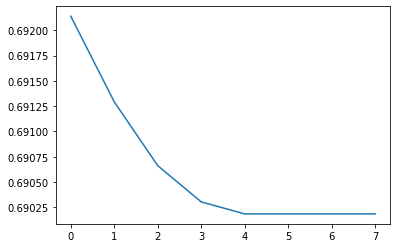

In [11]:
plt.plot(f_vals)